In [86]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool
from nltk.corpus import wordnet
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
from plotly.offline import iplot

In [87]:
df = pd.read_csv('tokenized_data.csv')

In [88]:
df

,Unnamed: 0,subreddit,body,controversiality,score,tokens
0,460253,freefolk,ffs mate do you really believe they put her on...,0,2,"['ffs', 'mate', 'do', '-PRON-', 'really', 'bel..."
1,388316,todayilearned,Piss prophets: your piss has blood in it - you...,0,5,"['piss', 'prophet', ':', '-PRON-', 'piss', 'ha..."
2,82023,SquaredCircle,Apparently they have a bunch of shoot whiners ...,0,1,"['apparently', '-PRON-', 'have', 'a', 'bunch',..."
3,295794,Animemes,I want to report to the FBI *but my feelings a...,0,2,"['-PRON-', 'want', 'to', 'report', 'to', 'the'..."
4,327326,leagueoflegends,Because she's only a problem in NA?,0,1,"['because', '-PRON-', 'be', 'only', 'a', 'prob..."
...,...,...,...,...,...,...
974995,166452,nba,Man fuck everyone who cheered hardens injury,0,14,"['man', 'fuck', 'everyone', 'who', 'cheer', 'h..."
974996,559920,FortNiteBR,It's not a bug. Its the Volcano rumbling prior...,0,4,"['-PRON-', 'be', 'not', 'a', 'bug', '.', '-PRO..."
974997,637196,unpopularopinion,You already have a biased opinion and are givi...,0,0,"['-PRON-', 'already', 'have', 'a', 'biased', '..."
974998,449951,nfl,I hate to say it but Bill Belichick deserves i...,0,52,"['-PRON-', 'hate', 'to', 'say', '-PRON-', 'but..."


In [89]:
#The maximum number of words
MAX_NB_WORDS = 5000
# Max number of words in each content.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 225361 unique tokens.


In [90]:
X = tokenizer.texts_to_sequences(df['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (975000, 250)


In [91]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (975000, 39)


In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(780000, 250) (780000, 39)
(195000, 250) (195000, 39)


In [93]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(39, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 39)                3939      
Total params: 5,084,339
Trainable params: 5,084,339
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
epochs = 10
batch_size = 128
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    )

Epoch 1/10
5485/5485 [==============================] - 2994s 546ms/step - loss: 2.2730 - accuracy: 0.3870 - val_loss: 2.1486 - val_accuracy: 0.4207
Epoch 2/10
5485/5485 [==============================] - 2561s 467ms/step - loss: 2.0533 - accuracy: 0.4455 - val_loss: 2.0574 - val_accuracy: 0.4475
Epoch 3/10
5485/5485 [==============================] - 2638s 481ms/step - loss: 1.9334 - accuracy: 0.4749 - val_loss: 2.0289 - val_accuracy: 0.4556
Epoch 4/10
5485/5485 [==============================] - 2546s 464ms/step - loss: 1.8527 - accuracy: 0.4945 - val_loss: 2.0285 - val_accuracy: 0.4590
Epoch 5/10
5485/5485 [==============================] - 1671s 305ms/step - loss: 1.7926 - accuracy: 0.5082 - val_loss: 2.0344 - val_accuracy: 0.4602
Epoch 6/10
5485/5485 [==============================] - 1550s 283ms/step - loss: 1.7462 - accuracy: 0.5188 - val_loss: 2.0584 - val_accuracy: 0.4607
Epoch 7/10
5485/5485 [==============================] - 1552s 283ms/step - loss: 1.7071 - accuracy: 0.5284

In [96]:
a = pd.get_dummies(df['subreddit'])
label = list(a.columns)

In [97]:
from sklearn.metrics import confusion_matrix

In [98]:
y_pred = model.predict(X_test)

In [99]:
matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

<Figure size 2160x1584 with 0 Axes>

<AxesSubplot:>

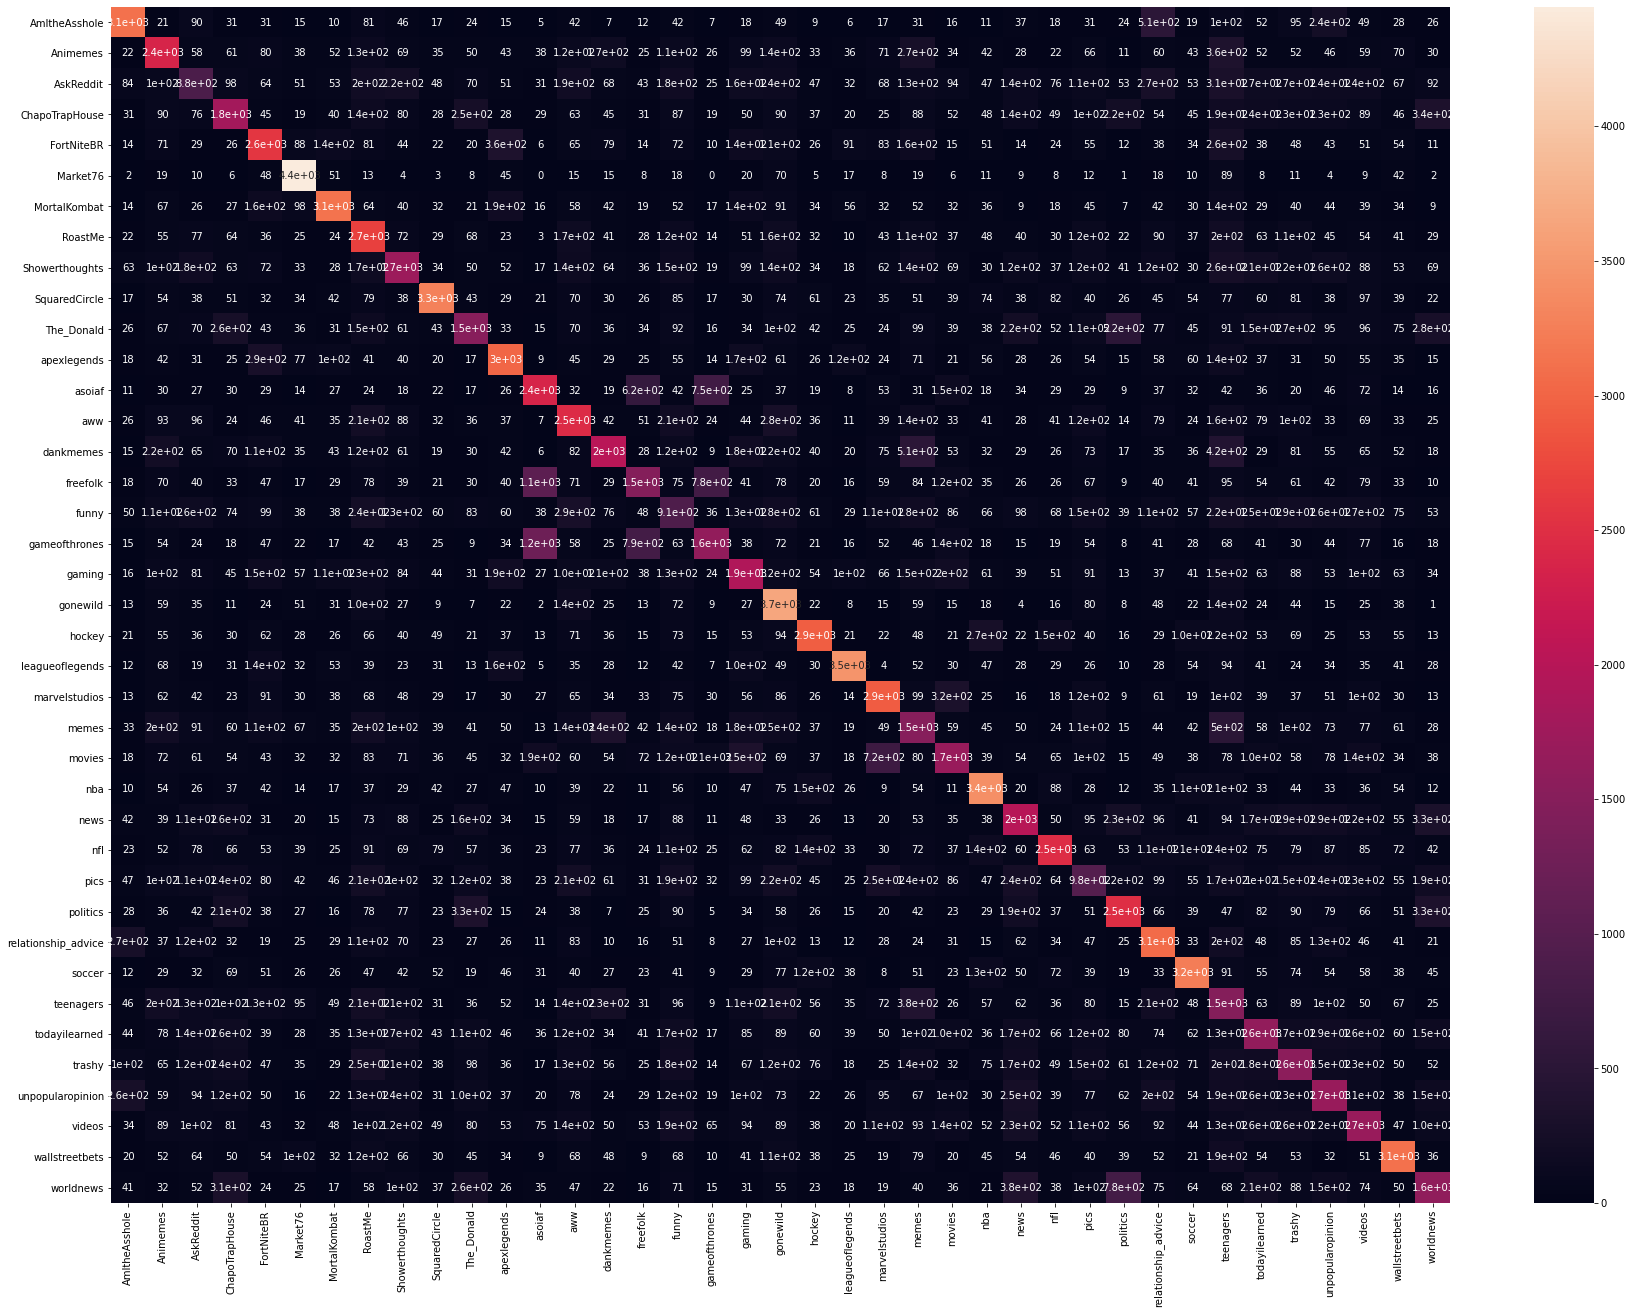

In [100]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in label],
                  columns = [i for i in label])
plt.figure(figsize = (30,22))
sn.heatmap(df_cm, annot=True)

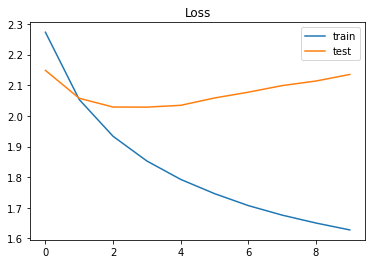

In [103]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [104]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6094/6094 [==============================] - 162s 27ms/step - loss: 2.1288 - accuracy: 0.4612
Test set
  Loss: 2.129
  Accuracy: 0.461


# Top10 accuracy re-classify

In [35]:
top10 = ['Market76','gonewild','relationship_advice','soccer','leagueoflegends',
      'wallstreetbets','AmItheAsshole','nba','SquaredCircle','apexlegends'
     ]

In [37]:
df2 = df[df['subreddit'].isin(top10)]

In [38]:
df2

,Unnamed: 0,subreddit,body,controversiality,score,tokens
2,82023,SquaredCircle,Apparently they have a bunch of shoot whiners ...,0,1,"['apparently', '-PRON-', 'have', 'a', 'bunch',..."
4,327326,leagueoflegends,Because she's only a problem in NA?,0,1,"['because', '-PRON-', 'be', 'only', 'a', 'prob..."
5,678565,relationship_advice,she is cheating on you.,0,1,"['-PRON-', 'be', 'cheat', 'on', '-PRON-', '.']"
6,309481,Market76,**Trader**|**+Karma**|**Cake Day**|**Submissio...,0,1,"['*', '*', 'trader**|**+karma**|**cake', 'Day*..."
7,554331,SquaredCircle,Was AOP on SD before they got injured? That’s ...,0,3,"['be', 'aop', 'on', 'sd', 'before', '-PRON-', ..."
...,...,...,...,...,...,...
974978,579127,wallstreetbets,Thought today would be very red. This is just...,0,1,"['thought', 'today', 'would', 'be', 'very', 'r..."
974985,647837,SquaredCircle,He did just defeat anti-semitism.,0,7,"['-PRON-', 'do', 'just', 'defeat', 'anti', '-'..."
974986,400970,leagueoflegends,ヽʕ •ᴥ•ʔﾉ Raise your koalas ヽʕ •ᴥ•ʔﾉ,0,12,"['ヽʕ', '•ᴥ•ʔﾉ', 'raise', '-PRON-', 'koalas', '..."
974992,593046,AmItheAsshole,"INFO. what do you mean by ""let her go""? Did yo...",0,5,"['INFO', '.', 'what', 'do', '-PRON-', 'mean', ..."


In [42]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df2['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 79378 unique tokens.


In [43]:
X = tokenizer.texts_to_sequences(df2['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (250000, 250)


In [44]:
Y = pd.get_dummies(df2['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (250000, 10)


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(200000, 250) (200000, 10)
(50000, 250) (50000, 10)


In [48]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
epochs = 10
batch_size = 128
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
1407/1407 [==============================] - 360s 256ms/step - loss: 1.2544 - accuracy: 0.5517 - val_loss: 0.8280 - val_accuracy: 0.7264
Epoch 2/10
1407/1407 [==============================] - 357s 254ms/step - loss: 0.7516 - accuracy: 0.7552 - val_loss: 0.7285 - val_accuracy: 0.7631
Epoch 3/10
1407/1407 [==============================] - 350s 249ms/step - loss: 0.6533 - accuracy: 0.7886 - val_loss: 0.7169 - val_accuracy: 0.7710
Epoch 4/10
1407/1407 [==============================] - 349s 248ms/step - loss: 0.5856 - accuracy: 0.8095 - val_loss: 0.7161 - val_accuracy: 0.7711
Epoch 5/10
1407/1407 [==============================] - 345s 246ms/step - loss: 0.5429 - accuracy: 0.8226 - val_loss: 0.7179 - val_accuracy: 0.7707
Epoch 6/10
1407/1407 [==============================] - 345s 245ms/step - loss: 0.5113 - accuracy: 0.8324 - val_loss: 0.7311 - val_accuracy: 0.7728
Epoch 7/10
1407/1407 [==============================] - 347s 247ms/step - loss: 0.4843 - accuracy: 0.8405 - val_

In [52]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1563/1563 [==============================] - 35s 23ms/step - loss: 0.7662 - accuracy: 0.7684
Test set
  Loss: 0.766
  Accuracy: 0.768


In [53]:
y_pred = model.predict(X_test)

In [54]:
matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

<Figure size 2160x1584 with 0 Axes>

<AxesSubplot:>

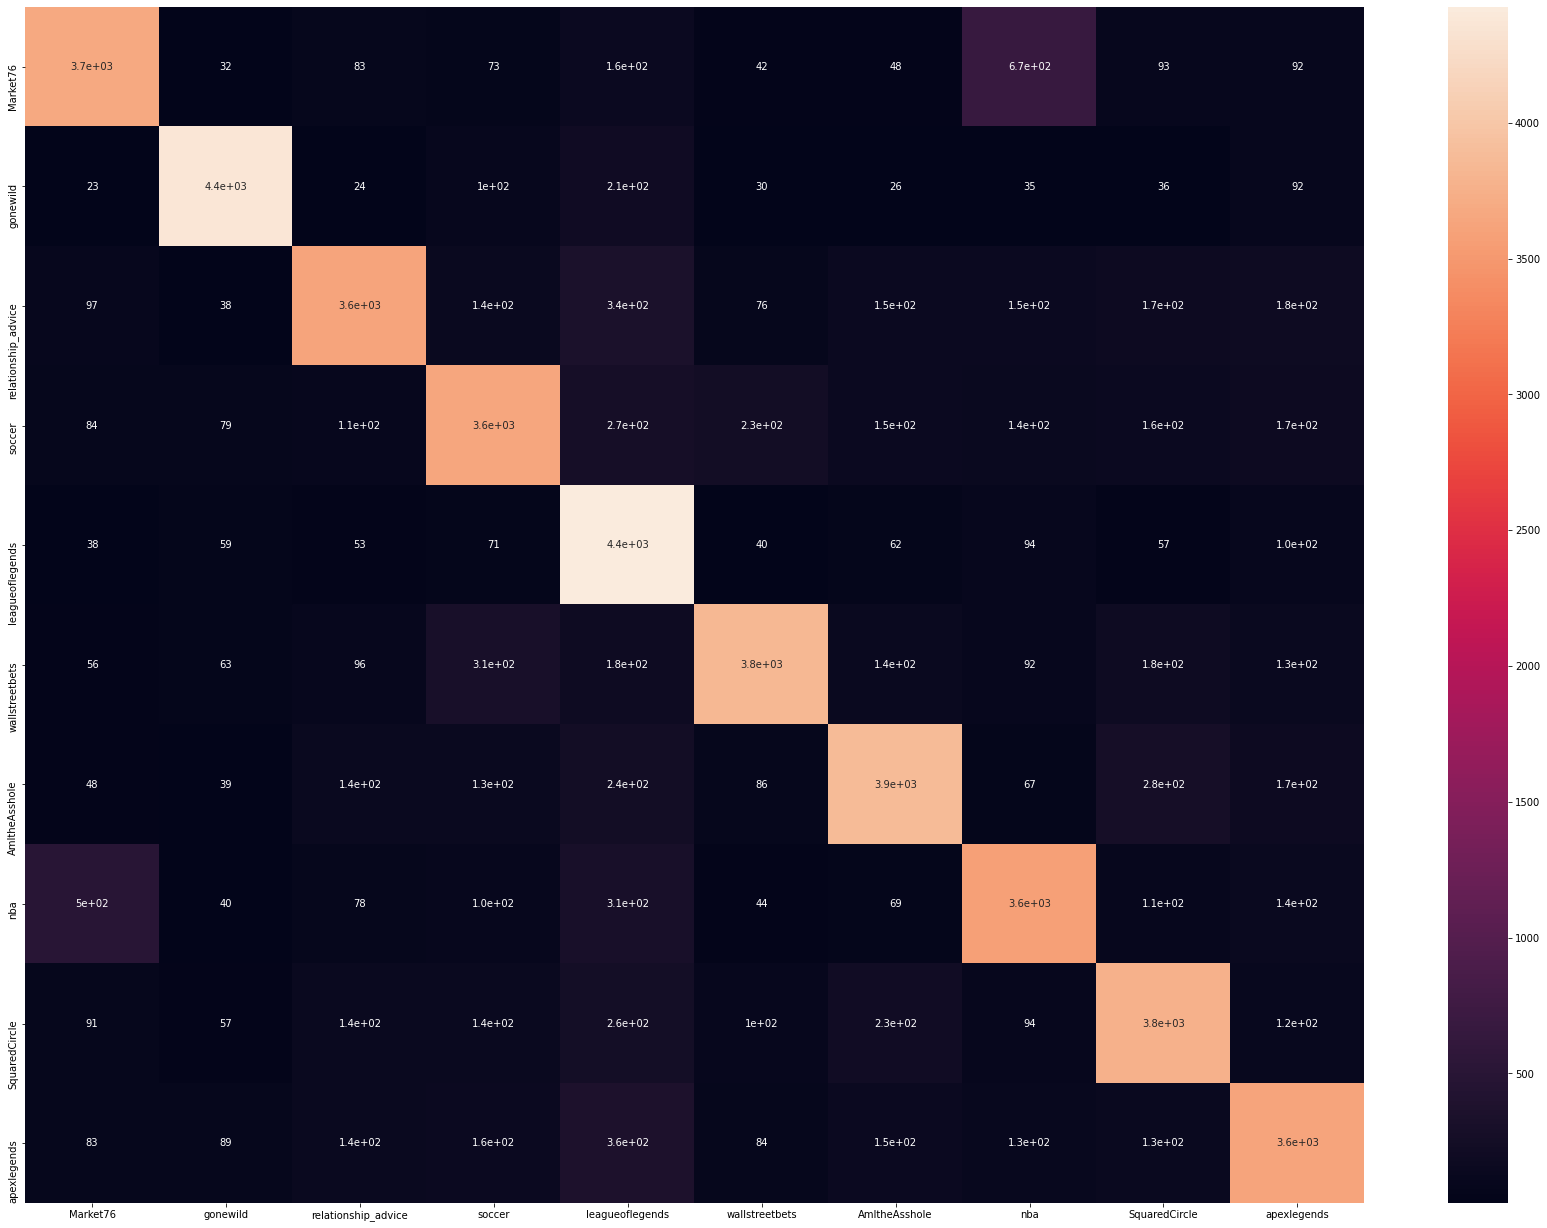

In [55]:
df_cm = pd.DataFrame(matrix, index = [i for i in top10],
                  columns = [i for i in top10])
plt.figure(figsize = (30,22))
sn.heatmap(df_cm, annot=True)

# Bottom10 accuracy re-classify

In [59]:
Bottom10 = ['funny','todayilearned','pics','AskReddit','gameofthrones',
      'memes','worldnews','The_Donald','unpopularopinion','ChapoTrapHouse']

In [60]:
df3 = df[df['subreddit'].isin(Bottom10)]

In [61]:
df3

,Unnamed: 0,subreddit,body,controversiality,score,tokens
1,388316,todayilearned,Piss prophets: your piss has blood in it - you...,0,5,"['piss', 'prophet', ':', '-PRON-', 'piss', 'ha..."
15,119906,AskReddit,"I said a bad word, I didn't know it was. The p...",0,2,"['-PRON-', 'say', 'a', 'bad', 'word', ',', '-P..."
18,748035,pics,"This is a university, not the Western Front.",1,35,"['this', 'be', 'a', 'university', ',', 'not', ..."
19,546819,funny,Karma Hos vs. the rest of reddit:\nhttps://www...,0,4,"['Karma', 'Hos', 'vs.', 'the', 'rest', 'of', '..."
28,336977,The_Donald,They are called white monkeys.,0,16,"['-PRON-', 'be', 'call', 'white', 'monkey', '.']"
...,...,...,...,...,...,...
974988,187178,memes,"Eh, compared to the storybook Sonic games, Son...",0,3,"['eh', ',', 'compare', 'to', 'the', 'storybook..."
974989,824518,pics,"It's a colossal squid, not a giant squid.",0,1,"['-PRON-', 'be', 'a', 'colossal', 'squid', ','..."
974993,377494,worldnews,And amazingly you guys pronounce the W in 'Oh'.,0,5,"['and', 'amazingly', '-PRON-', 'guy', 'pronoun..."
974997,637196,unpopularopinion,You already have a biased opinion and are givi...,0,0,"['-PRON-', 'already', 'have', 'a', 'biased', '..."


In [62]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df3['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 106111 unique tokens.


In [64]:
X = tokenizer.texts_to_sequences(df3['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (250000, 250)


In [65]:
Y = pd.get_dummies(df3['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (250000, 10)


In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(200000, 250) (200000, 10)
(50000, 250) (50000, 10)


In [67]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
epochs = 15
batch_size = 128
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/15
1407/1407 [==============================] - 350s 249ms/step - loss: 1.9068 - accuracy: 0.3157 - val_loss: 1.7059 - val_accuracy: 0.4123
Epoch 2/15
1407/1407 [==============================] - 343s 244ms/step - loss: 1.5828 - accuracy: 0.4616 - val_loss: 1.6067 - val_accuracy: 0.4550
Epoch 3/15
1407/1407 [==============================] - 345s 245ms/step - loss: 1.4190 - accuracy: 0.5254 - val_loss: 1.5746 - val_accuracy: 0.4740
Epoch 4/15
1407/1407 [==============================] - 356s 253ms/step - loss: 1.3023 - accuracy: 0.5656 - val_loss: 1.5704 - val_accuracy: 0.4807
Epoch 5/15
1407/1407 [==============================] - 356s 253ms/step - loss: 1.2197 - accuracy: 0.5935 - val_loss: 1.5969 - val_accuracy: 0.4807
Epoch 6/15
1407/1407 [==============================] - 348s 247ms/step - loss: 1.1462 - accuracy: 0.6163 - val_loss: 1.6353 - val_accuracy: 0.4782
Epoch 7/15
1407/1407 [==============================] - 342s 243ms/step - loss: 1.0845 - accuracy: 0.6358 - val_

In [69]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1563/1563 [==============================] - 36s 23ms/step - loss: 1.7116 - accuracy: 0.4737
Test set
  Loss: 1.712
  Accuracy: 0.474


In [70]:
y_pred = model.predict(X_test)

In [71]:
matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

<Figure size 2160x1584 with 0 Axes>

<AxesSubplot:>

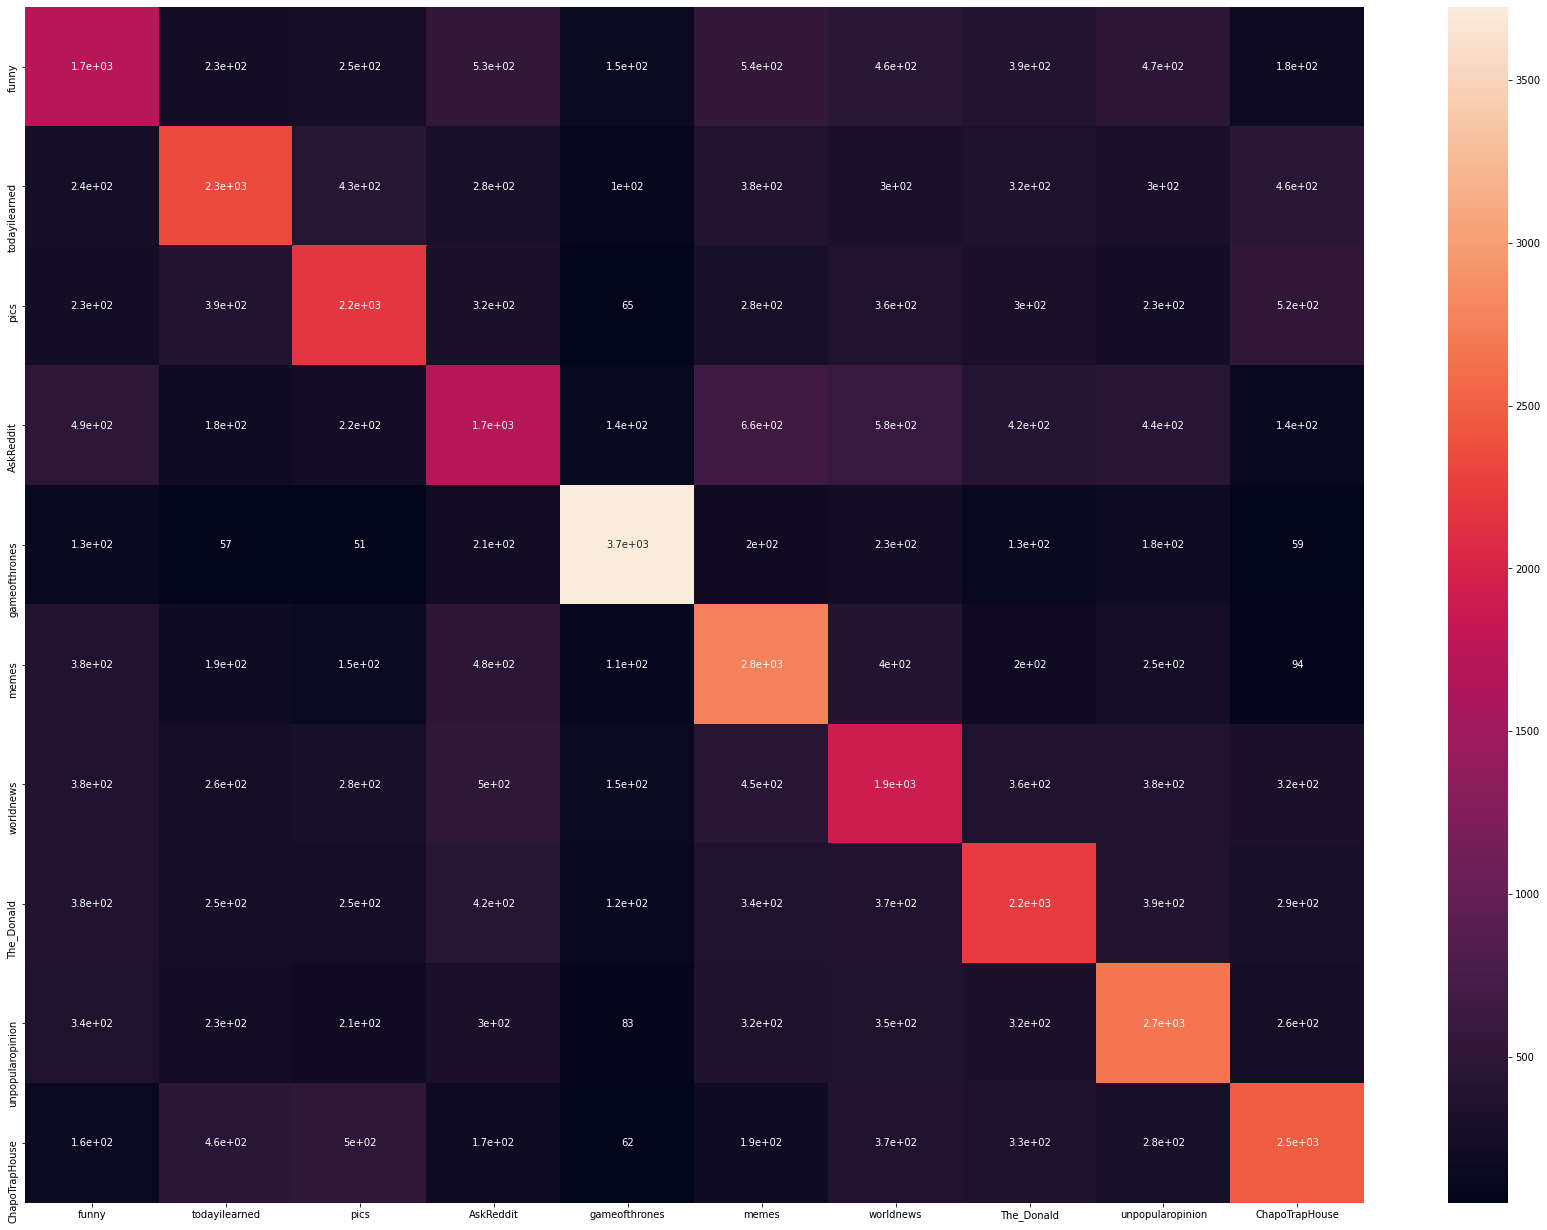

In [73]:
df_cm = pd.DataFrame(matrix, index = [i for i in Bottom10],
                  columns = [i for i in Bottom10])
plt.figure(figsize = (30,22))
sn.heatmap(df_cm, annot=True)